- [ ] CMPLNT_NUM -> unikalny numer dla każdego przestępstwa 
- [ ] ADDR_PCT_CD -> 77 police precincts, podzielone na dzielnice (https://www1.nyc.gov/site/nypd/bureaus/patrol/precincts-landing.page)
- [ ] BORO_NM -> nazwa dzielnicy gdzie wydarzył się incydent
- [ ] CMPLNT_FR_DT -> data wystąpienia przestępstwa
- [ ] CMPLNT_FR_TM -> godzina wystąpienia przestępstwa
- [ ] CMPLNT_TO_DT -> koniec wydarzenia
- [ ] CMPLNT_TO_TM -> koniec wydarzenia godzina
- [ ] CRM_ATPT_CPTD_CD -> znacznik czy zostało rozwiązane śledztwo 
- [ ] HADEVELOPT -> czy dana osoba pochodzi z housing development dla biedniejszych 
- [ ] HOUSING_PSA -> id housing development
- [ ] JURISDICTION_CODE -> do kogo nalezy przstepstwo
- [ ] JURIS_DESC -> do kogo nalezy przstepstwo
- [ ] KY_CD
- [ ] LAW_CAT_CD -> Level of offense: felony, misdemeanor, violation
- [ ] LOC_OF_OCCUR_DESC -> Specific location of occurrence in or around the premises; inside, opposite of, front of, rear of
- [ ] OFNS_DESC -> opis korespondujący z KY_CD kodem
- [ ] PARKS_NM -> nazwy miejsc gdzie się wydarzyły 
- [ ] PATROL_BORO -> patrol patrolujący 
- [ ] PD_CD -> bardzije 'ziarnisty' kod opisujący przestępstwo 
- [ ] PD_DESC -> bardzije 'ziarnisty' kod opisujący przestępstwo 
- [ ] PREM_TYP_DESC -> dokłądny rodzaj miejsca dokonania przestępstwa (może się łączyć spoko z LOC_OF_OCCUR_DESC, albo wykluczać tą zmienną)
- [ ] RPT_DT -> data zgłoszenia na policje 
- [ ] STATION_NAME -> komisariat gdzie zgłoszono przestępstwo 
- [ ] SUSP_AGE_GROUP -> grupa wiekowa podejrzanego 
- [ ] SUSP_RACE -> rasa podejrzanego 
- [ ] SUSP_SEX -> płeć podejrzanego 
- [ ] TRANSIT_DISTRICT 
- [ ] VIC_AGE_GROUP -> grupa wiekowa ofiary 
- [ ] VIC_RACE -> rasa ofiary 
- [ ] VIC_SEX -> płeć ofiary, Victim’s Sex Description (D=Business/Organization, E=PSNY/People of the State of New York, F=Female, M=Male)
- [ ] X_COORD_CD -> dane geo 
- [ ] Y_COORD_CD -> dane geo 
- [ ] Latitude -> dane geo 
- [ ] Longitude -> dane geo
- [ ] Lat_Lon -> dane geo

##### Aim of the project is to find patterns in data which will help NY police to optimize their efforts

### TO DO (CZYSZCZENIE):
- dorobić kolummny  time_span from crime to report
- przerobić opisy danych na nowe nazwy

### TO DO (POMYSŁY):
- nan przy danych przestępcy mogą być same w sobie informacja, warto sprwawdzić przy jaki przestępstwach wsytępują 
- czy w cieplejszyche misiacach wicej drobnych kradziży w stosunku do reszty? - napływ turystów do NY
- potrzebuje danych o ludności dzielnic aby przeliczyc dane w przestępstwach na osobe 

### TO DO (WIZUALIZACJE):
- według dni ilość przestępstw 
- według dzielnic
- przypadki na mapie 
- jakie rodzaje przestępstw sa najcześciej nierozwiazywalne

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
pd.set_option('display.max_columns',30)

## Loading and cleaning data

In [4]:
df = pd.read_excel("data.xlsx")

In [5]:
#cleaning data and preparing it for analysis
columns=['JURISDICTION_CODE', 'JURIS_DESC', 'KY_CD', 'PATROL_BORO', 'PD_CD', 'TRANSIT_DISTRICT', 'CMPLNT_NUM', 
         'CMPLNT_TO_DT', 'CMPLNT_TO_TM', 'X_COORD_CD', 'Y_COORD_CD']

to_del_susp_age_group = [-965,-966, -964, -973, -968, -64, 930, -1, -80, 947, 929, 1019, 940, 2019, 924]
to_del_vic_age_group = [-961, -952, 936, -71, -943, 956, -50, 941, -942, -39, 1013, -69, -67, 937, -946, -974, 951, 960, 
                        927, -2,938, -934, -978, -970, -56, -954, 943, 929, -967, 1018, -948]

#deleting columns
df.drop(columns=columns, inplace=True)

#changing values for boolean
df['CRM_ATPT_CPTD_CD'].replace({'COMPLETED':1, 'ATTEMPTED':0}, inplace=True)

#deleting wrong values from susp_age_group and vic_age_group columns

for x in to_del_susp_age_group:
    filt = df['SUSP_AGE_GROUP'] == x
    df.drop(index = df[filt].index, inplace=True)
    
for x in to_del_vic_age_group:
    filt = df['VIC_AGE_GROUP'] == x
    df.drop(index = df[filt].index, inplace=True)

#usunięcie wartości Nan z boro_nm i ofns_desc
df = df[~df['BORO_NM'].isnull()]
df = df[~df['VIC_AGE_GROUP'].isnull()]
df.dropna(how='any', subset=['OFNS_DESC', 'PREM_TYP_DESC'], inplace=True)

#changin and unifying values
df["SUSP_AGE_GROUP"].replace( np.nan, 'UNKNOWN', inplace=True)
df['SUSP_RACE'].replace(np.nan, 'UNKNOWN', inplace=True)
df['SUSP_SEX'].replace('U', 'UNKNOWN', inplace=True)

#changing type of data of columns with dates
date_columns = ['CMPLNT_FR_DT', 'RPT_DT']

for x in date_columns:
    df[x] = df[x].map(lambda x: datetime.datetime.strptime(x, '%m/%d/%Y'))
    df[x] = df[x].map(lambda x: x.date())

df['crime_day'] = df['CMPLNT_FR_DT'].map(lambda x: x.isoweekday())
df['crime_month'] = df['CMPLNT_FR_DT'].map(lambda x: x.month)
#df['time_span'] = pd.to_datetime(df['notification_date']) - pd.to_datetime(df['crime_day'])
    
df.columns = [x.lower() for x in df.columns]

In [6]:
#changing columns names for simpler and more unambiguous and reordering them
df.rename(columns={"cmplnt_num":'case_id', 'addr_pct_cd':'police_precincts', 'boro_nm':'district', 
                   'cmplnt_fr_dt':'crime_date', 'cmplnt_fr_tm':'crime_time','cmplnt_to_dt':'end_crime_date', 
                   'cmplnt_to_tm':'end_crime_time', 'crm_atpt_cptd_cd':'case_solved', 'hadevelopt': 'housing_dev_name',
                   'housing_psa':'id_housing_dev','law_cat_cd': 'ofns_level',
                   'pd_desc': 'detail_ofns_desc', 'rpt_dt': 'notification_date', 
                   'station_name':'notification_station_name'}, inplace=True)


"""
df = df['district', 'crime_date', 'crime_time', 'crime_day', 'crime_month', 'notification_date', 'time_span', 
       'case_solved', 'ofns_level', 'loc_of_occur_desc', 'ofns_desc', 'parks_nm', 
       'detail_ofns_desc', 'prem_typ_desc', 'susp_age_group', 'susp_race', 'susp_sex', 'vic_age_group', 
       'vic_race', 'vic_sex', 'latitude', 'longitude', 'lat_lon', 'police_precincts', 'housing_dev_name', 
        'id_housing_dev', 'notification_station_name']"""

"\ndf = df['district', 'crime_date', 'crime_time', 'crime_day', 'crime_month', 'notification_date', 'time_span', \n       'case_solved', 'ofns_level', 'loc_of_occur_desc', 'ofns_desc', 'parks_nm', \n       'detail_ofns_desc', 'prem_typ_desc', 'susp_age_group', 'susp_race', 'susp_sex', 'vic_age_group', \n       'vic_race', 'vic_sex', 'latitude', 'longitude', 'lat_lon', 'police_precincts', 'housing_dev_name', \n        'id_housing_dev', 'notification_station_name']"

In [7]:
df.to_csv('clean_data.csv')

In [51]:
#NY population by Borough
ny_population = {
    'District': ['Total', 'BRONX', 'BROOKLYN', 'MANHATTAN', 'QUEENS', 'STATEN ISLAND'],
    'Population': [8550971, 1446788, 2648452, 1638281, 2330295, 487155]
}
ny_population = pd.DataFrame(ny_population)
print(ny_population)
ny_population.set_index('District', inplace=True)

        District  Population
0          Total     8550971
1          BRONX     1446788
2       BROOKLYN     2648452
3      MANHATTAN     1638281
4         QUEENS     2330295
5  STATEN ISLAND      487155


## Initial exploration and further data preparation

In [14]:
df.head()

,police_precincts,district,crime_date,crime_time,case_solved,housing_dev_name,id_housing_dev,ofns_level,loc_of_occur_desc,ofns_desc,parks_nm,detail_ofns_desc,prem_typ_desc,notification_date,notification_station_name,susp_age_group,susp_race,susp_sex,vic_age_group,vic_race,vic_sex,latitude,longitude,lat_lon,crime_day,crime_month
0,48,BRONX,2019-12-31,18:00:00,1,NaN,NaN,FELONY,NaN,ROBBERY,NaN,"ROBBERY,PERSONAL ELECTRONIC DEVICE",STREET,2019-12-31,NaN,UNKNOWN,UNKNOWN,UNKNOWN,45-64,WHITE HISPANIC,F,40.838026,-73.881681,"(40.838026269000075, -73.88168118799997)",2,12
1,25,MANHATTAN,2019-12-30,20:30:00,1,NaN,NaN,MISDEMEANOR,INSIDE,PETIT LARCENY,NaN,"LARCENY,PETIT FROM BUILDING,UN",RESIDENCE - APT. HOUSE,2019-12-31,NaN,UNKNOWN,UNKNOWN,NaN,25-44,WHITE HISPANIC,F,40.800334,-73.945657,"(40.800334261000046, -73.94565697199994)",1,12
2,77,BROOKLYN,2019-12-24,16:55:00,1,NaN,NaN,FELONY,NaN,FELONY ASSAULT,NaN,"ASSAULT 2,1,UNCLASSIFIED",STREET,2019-12-31,NaN,UNKNOWN,BLACK,M,18-24,WHITE,M,40.669832,-73.939376,"(40.66983179600004, -73.93937555099996)",2,12
3,52,BRONX,2019-12-30,19:32:00,1,NaN,NaN,MISDEMEANOR,INSIDE,PETIT LARCENY,NaN,"LARCENY,PETIT FROM STORE-SHOPL",CHAIN STORE,2019-12-30,NaN,25-44,WHITE,F,UNKNOWN,UNKNOWN,D,40.873671,-73.908014,"(40.87367103500002, -73.90801364899994)",1,12
4,18,MANHATTAN,2019-12-30,15:30:00,1,NaN,NaN,MISDEMEANOR,NaN,PETIT LARCENY,NaN,"LARCENY,PETIT BY ACQUIRING LOS",STREET,2019-12-30,NaN,UNKNOWN,UNKNOWN,NaN,25-44,WHITE HISPANIC,M,40.760935,-73.994529,"(40.76093528000007, -73.99452906599998)",1,12


In [36]:
df['district'].value_counts(normalize=True)

BROOKLYN         0.287333
MANHATTAN        0.251437
BRONX            0.219166
QUEENS           0.200830
STATEN ISLAND    0.041235
Name: district, dtype: float64

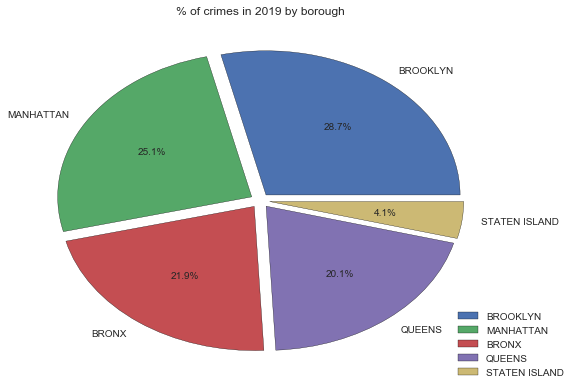

In [69]:
# %crimes by districts 
plt.style.use('seaborn')

pie_data = df['district'].value_counts(normalize=True)
explode = [0.05, 0.05, 0.05, 0.05, 0.05]
labels = df['district'].value_counts(normalize=True).index

plt.pie(pie_data, labels=labels, explode=explode, autopct='%1.1f%%', wedgeprops={'edgecolor': 'black'})

plt.title('% of crimes in 2019 by borough')
plt.legend(loc=(0.9,0))

plt.tight_layout() 

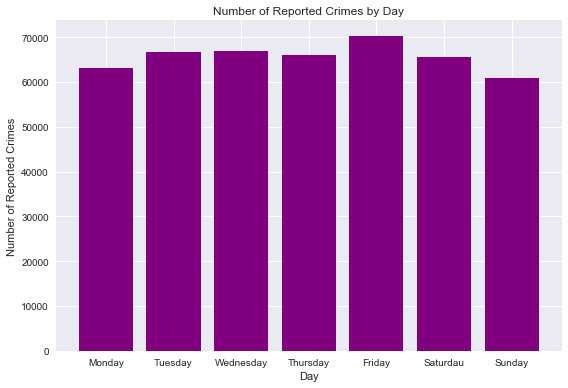

In [145]:
#number of crimes by day bar plot
bar_days = df['crime_day'].value_counts().sort_index()
ticks=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturdau', 'Sunday']
num = list(range(1,8))


plt.bar(bar_days.index, bar_days, color='purple')

plt.xticks(num, ticks)

plt.title('Number of Reported Crimes by Day')
plt.xlabel('Day')
plt.ylabel("Number of Reported Crimes")

plt.tight_layout() 

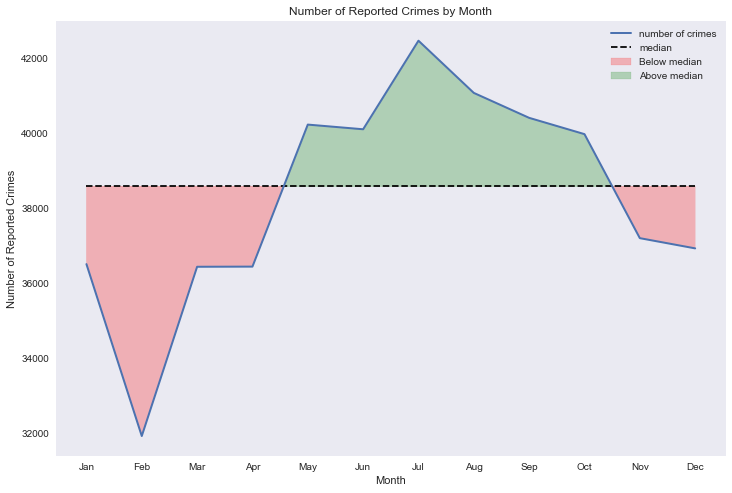

In [129]:
#number of crimes by month - line plot
ticks=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
num = list(range(1,13))
plt.figure(figsize=(12, 8))

crimes_month = df['crime_month'].value_counts().sort_index()
median = crimes_month.median()

plt.plot(crimes_month.index, crimes_month, label='number of crimes', linewidth=2)
plt.hlines(median, 1, 12, linestyle='--', label='median')

plt.title('Number of Reported Crimes by Month')
plt.xlabel('Month')
plt.ylabel("Number of Reported Crimes")
plt.xticks(num, ticks)

plt.fill_between(crimes_month.index, crimes_month,
                median, where=(median>crimes_month),
                interpolate=True,
                alpha=0.25,
                color='red',
                label='Below median'
                )

plt.fill_between(crimes_month.index, crimes_month,
                median, where=(median<=crimes_month),
                interpolate=True,
                alpha=0.25,
                color='green',
                label='Above median'
                )

plt.legend()
plt.grid(0)
#plt.plot(crimes_month.index, crimes_month)

In [152]:
#przestepstwa na dzielnice
df.columns
#df['case_solved'].value_counts()

Index(['police_precincts', 'district', 'crime_date', 'crime_time',
       'case_solved', 'housing_dev_name', 'id_housing_dev', 'ofns_level',
       'loc_of_occur_desc', 'ofns_desc', 'parks_nm', 'detail_ofns_desc',
       'prem_typ_desc', 'notification_date', 'notification_station_name',
       'susp_age_group', 'susp_race', 'susp_sex', 'vic_age_group', 'vic_race',
       'vic_sex', 'latitude', 'longitude', 'lat_lon', 'crime_day',
       'crime_month'],
      dtype='object')

In [170]:
#mapa przestęspstw 
%matplotlib qt
plt.figure(figsize=(12, 8))
lon = df['latitude']
lat = df['longitude']

plt.scatter(lat, lon, alpha=0.005)

Invalid requirement: 'pip''
Traceback (most recent call last):
  File "C:\Anaconda\lib\site-packages\pip\_vendor\packaging\requirements.py", line 93, in __init__
    req = REQUIREMENT.parseString(requirement_string)
  File "C:\Anaconda\lib\site-packages\pip\_vendor\pyparsing.py", line 1632, in parseString
    raise exc
  File "C:\Anaconda\lib\site-packages\pip\_vendor\pyparsing.py", line 1622, in parseString
    loc, tokens = self._parse( instring, 0 )
  File "C:\Anaconda\lib\site-packages\pip\_vendor\pyparsing.py", line 1379, in _parseNoCache
    loc,tokens = self.parseImpl( instring, preloc, doActions )
  File "C:\Anaconda\lib\site-packages\pip\_vendor\pyparsing.py", line 3395, in parseImpl
    loc, exprtokens = e._parse( instring, loc, doActions )
  File "C:\Anaconda\lib\site-packages\pip\_vendor\pyparsing.py", line 1383, in _parseNoCache
    loc,tokens = self.parseImpl( instring, preloc, doActions )
  File "C:\Anaconda\lib\site-packages\pip\_vendor\pyparsing.py", line 3183, in pars